# Setup

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd /content/drive/MyDrive/Data Open Championship 2022

/content/drive/MyDrive/Data Open Championship 2022


In [4]:
DATA_DIR = "2-data/IPEDS_Dataset_Encoded"
DATA_EXPORT_DIR = "2-data/preprocessed"

# Modeling

In [6]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA

## absolute

In [53]:
df_train = pd.read_csv(DATA_EXPORT_DIR + "/absolute/df_all_pub_train.csv")
df_test = pd.read_csv(DATA_EXPORT_DIR + "/absolute/df_all_pub_test.csv")
print(df_train.shape, df_test.shape)

(8044, 500) (2010, 500)


In [54]:
df_test.columns[df_test.columns.str.startswith("gradrate_4yr_completer150_")]
#vdf_test[df_test.columns[df_test.columns.str.startswith("fee")]]

Index(['gradrate_4yr_completer150_', 'gradrate_4yr_completer150_men',
       'gradrate_4yr_completer150_women', 'gradrate_4yr_completer150_black',
       'gradrate_4yr_completer150_hispanic', 'gradrate_4yr_completer150_white',
       'gradrate_4yr_completer150_asian'],
      dtype='object')

In [68]:
## configure predictors

response = "gradrate_2yr_completer150_"

predictors_finance = [
  "academic support - current year total",
"academic support - salaries and wages",
"additional (or decreased) pension expense",
"auxiliary enterprises -- current year total",
"auxiliary enterprises -- salaries and wages",
"institutional support - current year total",
"institutional support - salaries and wages",
"instruction - current year total",
"instruction - salaries and wages",
"public service - current year total",
"public service - salaries and wages",
"scholarships and fellowships expenses -- current year total",
"total gross scholarships and fellowships",
"student services - current year total",
"student services - salaries and wages",
 ]

predictors_finance = ["finance_" + col for col in predictors_finance]

predictors_finaid = [
    'finaid_scugrad', 'finaid_uagrntp',
    'finaid_uagrntt','finaid_upgrntp', 
    'finaid_upgrntt', 'finaid_ufloanp', 
    'finaid_ufloant', 'finaid_ugpo9_t',
    'finaid_ugpo9_a', 'finaid_gpo9_t', 'finaid_gpo9_a',
    'finaid_po9_t', 'finaid_po9_a', 
    'finaid_ugdod_t', 'finaid_ugdod_a', 
    'finaid_gdod_t', 'finaid_gdod_a', 'finaid_dod_t'
]

predictors_fee = [
    'fee_tuition1', 'fee_fee1', 'fee_hrchg1', 'fee_tuition2', 'fee_fee2',
       'fee_hrchg2', 'fee_tuition3', 'fee_fee3', 'fee_hrchg3', 'fee_tuition5',
       'fee_fee5', 'fee_hrchg5', 'fee_tuition6', 'fee_fee6', 'fee_hrchg6',
       'fee_tuition7', 'fee_fee7', 'fee_hrchg7', 'fee_chg3tgtd',
       'fee_chg3fgtd', 'fee_chg4ay3', 'fee_chg3ay3', 'fee_chg6ay3',
       'fee_chg7ay3', 'fee_chg8ay3'
]

covariates = ["time"]
covariates += df_test.columns[df_test.columns.str.startswith("charac")].tolist()
covariates += df_test.columns[df_test.columns.str.startswith("diversity")].tolist()
covariates += df_test.columns[df_test.columns.str.startswith("services")].tolist()
covariates += df_test.columns[df_test.columns.str.startswith("speclearning")].tolist()

print(len(predictors_finance), len(predictors_fee), len(predictors_finaid))
print(len(covariates))
covariates.remove("speclearning_distanceonly")

predictors = predictors_finance + predictors_fee + predictors_finaid
predictors = predictors_finance + predictors_fee + predictors_finaid
#predictors = []
print(len(predictors) + len(covariates))

15 25 18
28
85


In [69]:
# log transform cost variables 
for col in predictors_finance + ['finaid_upgrntt', 'finaid_ufloant', 'finaid_ugpo9_t',
    'finaid_gpo9_t', 'finaid_gpo9_a','finaid_po9_t', 'finaid_po9_a', 'finaid_ugdod_a', 
    'finaid_gdod_t', 'finaid_gdod_a', 'finaid_dod_t', 'finaid_ugdod_t']:

    df_train[col] = np.log(df_train[col]+0.1)
    df_test[col] = np.log(df_test[col]+0.1)

***Train: (4342, 85)    Test: (1150, 85)


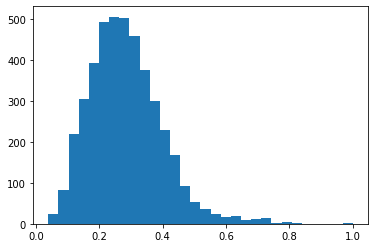

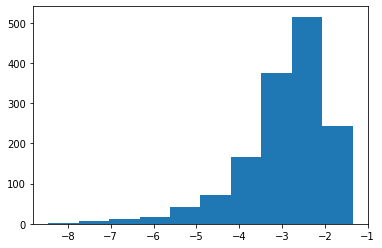

In [70]:
# prepare train and test
y_train = df_train[response]
y_test = df_test[response]
X_train = df_train[predictors + covariates][~y_train.isnull()]
X_test = df_test[predictors + covariates][~y_test.isnull()]
y_train = np.asarray(y_train[~y_train.isnull()])
y_test = np.asarray(y_test[~y_test.isnull()])
print("***Train:", X_train.shape, "   Test:", X_test.shape)
plt.hist(y_train, 30)
plt.show()
plt.hist(X_train['finaid_ugdod_t'])
plt.show()

In [71]:
X_train.isnull().sum()[:10]

finance_academic support - current year total           615
finance_academic support - salaries and wages           618
finance_additional (or decreased) pension expense      1782
finance_auxiliary enterprises -- current year total    1193
finance_auxiliary enterprises -- salaries and wages    1545
finance_institutional support - current year total      615
finance_institutional support - salaries and wages      618
finance_instruction - current year total                615
finance_instruction - salaries and wages                615
finance_public service - current year total            2048
dtype: int64

In [72]:
X_train.isnull().sum(axis=1).value_counts()[:10]

22    664
21    538
23    528
24    524
20    462
19    271
25    262
26    178
36    169
18    122
dtype: int64

In [73]:
#X_train.fillna(X_train.median(), inplace=True)
#X_test.fillna(X_test.median(), inplace=True)
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)

MSE = 0.009   Corr = 0.584
MSE = 0.009   Corr = 0.498


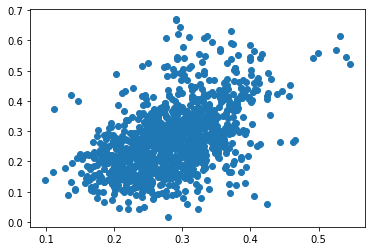

In [74]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_train)
print(f"MSE ={ mean_squared_error(y_train, y_pred.flatten()) : .3f}   Corr ={np.corrcoef(y_train, y_pred.flatten())[0][1]: .3f}")
y_pred = model.predict(X_test)
print(f"MSE ={ mean_squared_error(y_test, y_pred.flatten()) : .3f}   Corr ={np.corrcoef(y_test, y_pred.flatten())[0][1]: .3f}")
plt.scatter(y_pred, y_test)
plt.show()

In [49]:
coefs = pd.DataFrame(model.coef_, index=predictors+covariates)
coefs.columns = ["linear regression coef"]
coefs.sort_values("linear regression coef", ascending=False)[:10]

,linear regression coef
finaid_po9_t,16268.550476
finaid_gpo9_t,2579.793804
finance_institutional support - salaries and wages,2084.702954
finance_instruction - current year total,1727.928431
finaid_dod_t,1114.142724
finaid_ufloant,1052.047652
charac_medical,893.499243
services_counseling,579.249485
services_library_digital,505.160740
finance_student services - current year total,494.798257


In [50]:
coefs.sort_values("linear regression coef", ascending=True)[:10]

,linear regression coef
finaid_ugpo9_t,-15612.644225
finaid_gpo9_a,-3148.053847
finance_student services - salaries and wages,-2916.163834
finaid_upgrntt,-2087.278717
finance_total gross scholarships and fellowships,-1247.044992
finaid_ugdod_t,-1115.464611
diversity_tribal,-973.727942
finance_academic support - salaries and wages,-680.863624
finance_institutional support - current year total,-620.548623
finaid_po9_a,-608.182843


MSE = 710121.383   Corr = 0.954
MSE = 787287.825   Corr = 0.937


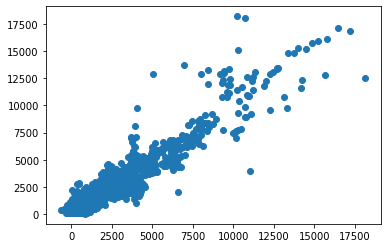

In [51]:
model = PLSRegression(n_components=10)
model.fit(X_train, y_train)
y_pred = model.predict(X_train)
print(f"MSE ={ mean_squared_error(y_train, y_pred.flatten()) : .3f}   Corr ={np.corrcoef(y_train, y_pred.flatten())[0][1]: .3f}")
y_pred = model.predict(X_test)
print(f"MSE ={ mean_squared_error(y_test, y_pred.flatten()) : .3f}   Corr ={np.corrcoef(y_test, y_pred.flatten())[0][1]: .3f}")
plt.scatter(y_pred, y_test)
plt.show()

MSE = 875935.436   Corr = 0.942
MSE = 858271.112   Corr = 0.931


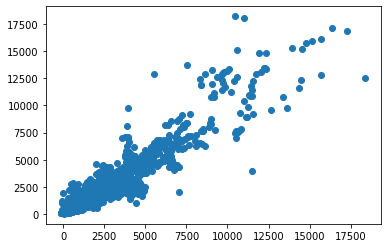

In [52]:
model = PCA(n_components=10)
U_train = model.fit_transform(X_train)
U_test = model.transform(X_test)
model = LinearRegression()
model.fit(U_train, y_train)

y_pred = model.predict(U_train)
print(f"MSE ={ mean_squared_error(y_train, y_pred.flatten()) : .3f}   Corr ={np.corrcoef(y_train, y_pred.flatten())[0][1]: .3f}")
y_pred = model.predict(U_test)
print(f"MSE ={ mean_squared_error(y_test, y_pred.flatten()) : .3f}   Corr ={np.corrcoef(y_test, y_pred.flatten())[0][1]: .3f}")
plt.scatter(y_pred, y_test)
plt.show()

## relative

In [ ]:
df_train = pd.read_csv(DATA_EXPORT_DIR + "/relative/df_all_pub_train_long.csv")
df_test = pd.read_csv(DATA_EXPORT_DIR + "/relative/df_all_pub_test_long.csv")
print(df_train.shape, df_test.shape)

(5755, 499) (1440, 499)


In [ ]:
df_test.columns[df_test.columns.str.startswith("gradrate_4yr_completer150_")]

Index(['gradrate_4yr_completer150_men', 'gradrate_4yr_completer150_women',
       'gradrate_4yr_completer150_black', 'gradrate_4yr_completer150_hispanic',
       'gradrate_4yr_completer150_white', 'gradrate_4yr_completer150_asian'],
      dtype='object')

In [ ]:
predictors_finance = [
  "academic support - current year total",
"academic support - salaries and wages",
"additional (or decreased) pension expense",
"auxiliary enterprises -- current year total",
"auxiliary enterprises -- salaries and wages",
"institutional support - current year total",
"institutional support - salaries and wages",
"instruction - current year total",
"instruction - salaries and wages",
"public service - current year total",
"public service - salaries and wages",
"scholarships and fellowships expenses -- current year total",
"total gross scholarships and fellowships",
"student services - current year total",
"student services - salaries and wages",
 ]

predictors_finance = ["finance_" + col for col in predictors_finance]

predictors_fee = [
    'fee_tuition1', 'fee_fee1', 'fee_hrchg1', 'fee_tuition2', 'fee_fee2',
       'fee_hrchg2', 'fee_tuition3', 'fee_fee3', 'fee_hrchg3', 'fee_tuition5',
       'fee_fee5', 'fee_hrchg5', 'fee_tuition6', 'fee_fee6', 'fee_hrchg6',
       'fee_tuition7', 'fee_fee7', 'fee_hrchg7', 'fee_chg3tgtd',
       'fee_chg3fgtd', 'fee_chg4ay3', 'fee_chg3ay3', 'fee_chg6ay3',
       'fee_chg7ay3', 'fee_chg8ay3'
]

covariates = [] 
covariates += df_test.columns[df_test.columns.str.startswith("charac")].tolist()
covariates += df_test.columns[df_test.columns.str.startswith("diversity")].tolist()
covariates += df_test.columns[df_test.columns.str.startswith("services")].tolist()
covariates += df_test.columns[df_test.columns.str.startswith("speclearning")].tolist()

print(len(predictors_finance), len(predictors_fee), len(predictors_finaid))
print(len(covariates))

predictors = predictors_finance + predictors_fee + predictors_finaid

15 25 18
27


***Train: (2013, 85)    Test: (468, 85)


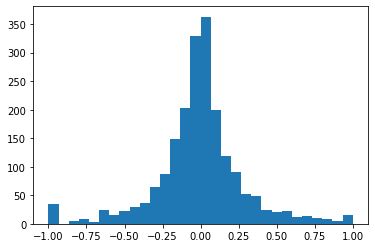

In [ ]:
y_train = df_train['gradrate_4yr_completer150_black']
y_test = df_test['gradrate_4yr_completer150_black']
X_train = df_train[predictors + covariates][~y_train.isnull()]
X_test = df_test[predictors + covariates][~y_test.isnull()]
y_train = np.asarray(y_train[~y_train.isnull()])
y_test = np.asarray(y_test[~y_test.isnull()])
print("***Train:", X_train.shape, "   Test:", X_test.shape)
plt.hist(y_train, 30)
plt.show()

In [ ]:
X_train.isnull().sum(axis=1).value_counts()[:10]

4     305
3     282
2     239
5     197
6     144
17    131
18    100
7      93
8      82
19     80
dtype: int64

In [ ]:
X_train.isnull().sum()[:20]

finance_academic support - current year total                           434
finance_academic support - salaries and wages                           439
finance_additional (or decreased) pension expense                      1029
finance_auxiliary enterprises -- current year total                     436
finance_auxiliary enterprises -- salaries and wages                     449
finance_institutional support - current year total                      438
finance_institutional support - salaries and wages                      442
finance_instruction - current year total                                430
finance_instruction - salaries and wages                                432
finance_public service - current year total                             474
finance_public service - salaries and wages                             491
finance_scholarships and fellowships expenses -- current year total     484
finance_total gross scholarships and fellowships                        433
finance_stud

In [ ]:
#X_train.fillna(X_train.median(), inplace=True)
#X_test.fillna(X_test.median(), inplace=True)
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)
#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)

In [ ]:
np.min(np.min(X_train))

-137.55538367574826

In [ ]:
model = PLSRegression(n_components=10)
#model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_train)
print(f"MSE ={ mean_squared_error(y_train, y_pred.flatten()) : .3f}   Corr ={np.corrcoef(y_train, y_pred.flatten())[0][1]: .3f}")
y_pred = model.predict(X_test)
print(f"MSE ={ mean_squared_error(y_test, y_pred.flatten()) : .3f}   Corr ={np.corrcoef(y_test, y_pred.flatten())[0][1]: .3f}")


MSE = 0.080   Corr = 0.255
MSE = 0.082   Corr = 0.072


MSE = 0.084   Corr = 0.144
MSE = 0.078   Corr = 0.146


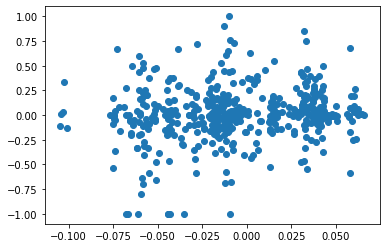

In [ ]:
model = PCA(n_components=10)
U_train = model.fit_transform(X_train)
U_test = model.transform(X_test)
model = LinearRegression()
model.fit(U_train, y_train)

y_pred = model.predict(U_train)
print(f"MSE ={ mean_squared_error(y_train, y_pred.flatten()) : .3f}   Corr ={np.corrcoef(y_train, y_pred.flatten())[0][1]: .3f}")
y_pred = model.predict(U_test)
print(f"MSE ={ mean_squared_error(y_test, y_pred.flatten()) : .3f}   Corr ={np.corrcoef(y_test, y_pred.flatten())[0][1]: .3f}")
plt.scatter(y_pred, y_test)
plt.show()